<a href="https://colab.research.google.com/github/saitzaw/apache-spark-colab/blob/main/Resolution2023_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install PySpark in Colab


In [1]:
!pip install -q findspark
!pip install -q pyspark

In [2]:
import os
import folium
import sqlite3
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row
from datetime import datetime, date
from pyspark.sql.types import StructType,StructField,DateType, DoubleType
from pyspark.sql.functions import date_format, to_date, year, month, days

In [3]:
findspark.init()
spark = SparkSession.builder\
                    .master("local")\
                    .appName("Resolution2023")\
                    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

# Data line 
- Note, original data is converted to parquet
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

# Mount to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
SampleData = '/content/drive/MyDrive/ColabDataset/MotorVehicleCollisionsCrashes.parquet'

In [6]:
MVCCDF = spark.read.parquet(SampleData)

# Investigate the data format
- pandas, df.head()
- PySpark, DF.show(5, truncate=True, vertical=False)
- MySQL, use SELECT * FROM TableName limit 5 \G 
- Postgresql, \x

In [7]:
MVCCDF.show(1, truncate = True, vertical=True)

-RECORD 0---------------------------------------------
 CRASH_DATE                    | 04/14/2021           
 CRASH_TIME                    | 5:32                 
 BOROUGH                       | null                 
 ZIP_CODE                      | null                 
 LATITUDE                      | null                 
 LONGITUDE                     | null                 
 LOCATION                      | null                 
 ON_STREET_NAME                | BRONX WHITESTONE ... 
 CROSS_STREET_NAME             | null                 
 OFF_STREET_NAME               | null                 
 NUMBER_OF_PERSONS_INJURED     | 0.0                  
 NUMBER_OF_PERSONS_KILLED      | 0.0                  
 NUMBER_OF_PEDESTRIANS_INJURED | 0                    
 NUMBER_OF_PEDESTRIANS_KILLED  | 0                    
 NUMBER_OF_CYCLIST_INJURED     | 0                    
 NUMBER_OF_CYCLIST_KILLED      | 0                    
 NUMBER_OF_MOTORIST_INJURED    | 0                    
 NUMBER_OF

In [8]:
MVCCDF.printSchema()

root
 |-- CRASH_DATE: string (nullable = true)
 |-- CRASH_TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP_CODE: double (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON_STREET_NAME: string (nullable = true)
 |-- CROSS_STREET_NAME: string (nullable = true)
 |-- OFF_STREET_NAME: string (nullable = true)
 |-- NUMBER_OF_PERSONS_INJURED: double (nullable = true)
 |-- NUMBER_OF_PERSONS_KILLED: double (nullable = true)
 |-- NUMBER_OF_PEDESTRIANS_INJURED: long (nullable = true)
 |-- NUMBER_OF_PEDESTRIANS_KILLED: long (nullable = true)
 |-- NUMBER_OF_CYCLIST_INJURED: long (nullable = true)
 |-- NUMBER_OF_CYCLIST_KILLED: long (nullable = true)
 |-- NUMBER_OF_MOTORIST_INJURED: long (nullable = true)
 |-- NUMBER_OF_MOTORIST_KILLED: long (nullable = true)
 |-- CONTRIBUTING_FACTOR_VEHICLE_1: string (nullable = true)
 |-- CONTRIBUTING_FACTOR_VEHICLE_2: string (nullable = tru

# Change date format 
- pandas, pd.to_datetime(df['date'])
- PySpark, from pyspark.sql import functions as F 
- DF.withColumns("DATE", F.date_time(F.to_date("DATE", "dd/MM/yyyy"), "yyyy-MM-dd") 
- PySpark, from pyspark.sql.functions import to_date, date_time //use this
- DF.withColumns("DATE", date_time(to_date("DATE", "dd/MM/yyyy"), "yyyy-MM-dd")

# Change Column name to inprove readability 
-pandas, df.rename({'old_col_name1': 'new_col_name2', 'old_col_name2':'new_col_name3'}, axis=1, inplace=True)
- PySpark, DF.withColumnRenamed("old_col_name1", "new_col_name1")\.withColumnRenamed("old_col_name2", "new_col_name2").drop('columns')

In [9]:
MVCCDfAnalysis = MVCCDF.withColumn(
    "CRASH_DATE", date_format(to_date("CRASH_DATE", "MM/dd/yyyy"), "yyyy-MM-dd"))\
.withColumnRenamed("CRASH_DATE", "crash_date")\
.withColumnRenamed("CRASH_TIME", "crash_time")\
.withColumnRenamed("BOROUGH", "borough")\
.withColumnRenamed("ZIP_CODE", "zip")\
.withColumnRenamed("LATITUDE", "lat")\
.withColumnRenamed("LONGITUDE", "long")\
.withColumnRenamed("LOCATION", "loca")\
.withColumnRenamed("ON_STREET_NAME", "on_street_name")\
.withColumnRenamed("CROSS_STREET_NAME", "cross_street_name")\
.withColumnRenamed("OFF_STREET_NAME", "off_street_name")\
.withColumnRenamed("NUMBER_OF_PERSONS_INJURED", "num_person_injured")\
.withColumnRenamed("NUMBER_OF_PERSONS_KILLED", "num_person_killed")\
.withColumnRenamed("NUMBER_OF_PEDESTRIANS_INJURED", "num_pedestrians_injured")\
.withColumnRenamed("NUMBER_OF_PEDESTRIANS_KILLED", "num_pedestrians_killed")\
.withColumnRenamed("NUMBER_OF_CYCLIST_INJURED", "num_cyclist_injured")\
.withColumnRenamed("NUMBER_OF_CYCLIST_KILLED", "num_cyclist_killed")\
.withColumnRenamed("NUMBER_OF_MOTORIST_INJURED", "num_motorist_injured")\
.withColumnRenamed("NUMBER_OF_MOTORIST_KILLED", "num_motorist_killed")\
.withColumnRenamed("CONTRIBUTING_FACTOR_VEHICLE_1", "contributing_factor_venicle_1")\
.withColumnRenamed("CONTRIBUTING_FACTOR_VEHICLE_2", "contributing_factor_venicle_2")\
.withColumnRenamed("CONTRIBUTING_FACTOR_VEHICLE_3", "contributing_factor_venicle_3")\
.withColumnRenamed("CONTRIBUTING_FACTOR_VEHICLE_4", "contributing_factor_venicle_4")\
.withColumnRenamed("CONTRIBUTING_FACTOR_VEHICLE_5", "contributing_factor_venicle_5")\
.withColumnRenamed("COLLISION_ID", "collision_id")\
.withColumnRenamed("VEHICLE_TYPE_CODE_1", "venicle_type_code_1")\
.withColumnRenamed("VEHICLE_TYPE_CODE_2", "venicle_type_code_2")\
.withColumnRenamed("VEHICLE_TYPE_CODE_3", "venicle_type_code_3")\
.withColumnRenamed("VEHICLE_TYPE_CODE_4", "venicle_type_code_4")\
.withColumnRenamed("VEHICLE_TYPE_CODE_5", "venicle_type_code_5")

In [10]:
MVCCDfAnalysis.show(1, truncate=False, vertical=True)

-RECORD 0------------------------------------------------
 crash_date                    | 2021-04-14              
 crash_time                    | 5:32                    
 borough                       | null                    
 zip                           | null                    
 lat                           | null                    
 long                          | null                    
 loca                          | null                    
 on_street_name                | BRONX WHITESTONE BRIDGE 
 cross_street_name             | null                    
 off_street_name               | null                    
 num_person_injured            | 0.0                     
 num_person_killed             | 0.0                     
 num_pedestrians_injured       | 0                       
 num_pedestrians_killed        | 0                       
 num_cyclist_injured           | 0                       
 num_cyclist_killed            | 0                       
 num_motorist_

In [11]:
MVCCDfAnalysis.filter(MVCCDfAnalysis["num_person_killed"] >= 1).count()

1439

In [12]:
MVCCDfAnalysis.filter(MVCCDfAnalysis["num_person_injured"] >= 1).count()

240742

# Check the people passed away by car crash

In [13]:
MVCCDKilled = MVCCDfAnalysis.filter(MVCCDfAnalysis["num_person_killed"] >= 1)\
.filter(MVCCDfAnalysis['contributing_factor_venicle_1'].isNotNull())\
.withColumn("crash_year", year(MVCCDfAnalysis["crash_date"]))\
.withColumn("crash_month", month(MVCCDfAnalysis["crash_date"]))\
.withColumn("crash_day", date_format(MVCCDfAnalysis["crash_date"], "d"))\
.select("collision_id", "crash_date", 
        "crash_year","crash_month", "crash_day",
        "crash_time","borough", 
        "loca", "num_person_killed",
        "num_pedestrians_killed",
        "num_cyclist_killed", 
        "num_motorist_killed")

In [14]:
MVCCDKilled.show(10, truncate=False, vertical=False)

+------------+----------+----------+-----------+---------+----------+---------+-------------------------+-----------------+----------------------+------------------+-------------------+
|collision_id|crash_date|crash_year|crash_month|crash_day|crash_time|borough  |loca                     |num_person_killed|num_pedestrians_killed|num_cyclist_killed|num_motorist_killed|
+------------+----------+----------+-----------+---------+----------+---------+-------------------------+-----------------+----------------------+------------------+-------------------+
|4408063     |2021-04-15|2021      |4          |15       |15:18     |BROOKLYN |(40.620487, -74.029305)  |1.0              |1                     |0                 |0                  |
|4407693     |2021-04-15|2021      |4          |15       |22:36     |null     |null                     |1.0              |0                     |0                 |1                  |
|4408695     |2021-04-18|2021      |4          |18       |23:56     |n

In [15]:
MVCCDKilled.filter(MVCCDKilled["crash_year"] != 2022)\
.groupBy("crash_year")\
.sum("num_person_killed")\
.orderBy("crash_year")\
.show(truncate=True)

+----------+----------------------+
|crash_year|sum(num_person_killed)|
+----------+----------------------+
|      2016|                 135.0|
|      2017|                 255.0|
|      2018|                 230.0|
|      2019|                 243.0|
|      2020|                 267.0|
|      2021|                 282.0|
+----------+----------------------+



In [16]:
MVCCDKilled.filter(MVCCDKilled["crash_year"] != 2022)\
.groupBy("crash_year", "crash_month")\
.sum("num_person_killed")\
.orderBy("crash_year", "crash_month")\
.show(truncate=True)

+----------+-----------+----------------------+
|crash_year|crash_month|sum(num_person_killed)|
+----------+-----------+----------------------+
|      2016|          6|                   9.0|
|      2016|          7|                  19.0|
|      2016|          8|                  29.0|
|      2016|          9|                  18.0|
|      2016|         10|                  19.0|
|      2016|         11|                  17.0|
|      2016|         12|                  24.0|
|      2017|          1|                  18.0|
|      2017|          2|                  13.0|
|      2017|          3|                  17.0|
|      2017|          4|                  22.0|
|      2017|          5|                  13.0|
|      2017|          6|                  21.0|
|      2017|          7|                  32.0|
|      2017|          8|                  23.0|
|      2017|          9|                  28.0|
|      2017|         10|                  28.0|
|      2017|         11|                

In [17]:
MVCCDFKilledData = MVCCDKilled.filter(MVCCDKilled["crash_year"] != 2022)\
.groupBy("crash_year", "crash_month")\
.sum("num_person_killed")\
.withColumnRenamed("Sum(num_person_killed)", "total_ppl_killed")\
.orderBy("crash_year", "crash_month")

In [18]:
MVCCDFKilledData.show(1, truncate=False)

+----------+-----------+----------------+
|crash_year|crash_month|total_ppl_killed|
+----------+-----------+----------------+
|2016      |6          |9.0             |
+----------+-----------+----------------+
only showing top 1 row



# Plot all data

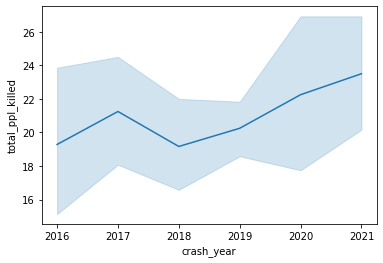

In [19]:
mvcc_df_killed_data = MVCCDFKilledData.toPandas()
sns.lineplot(x="crash_year", y="total_ppl_killed", data=mvcc_df_killed_data)

# Select 2016 data

In [20]:
MVCCDf16 = MVCCDKilled.filter(MVCCDKilled["crash_year"] == 2016)\
.groupBy("crash_year", "crash_month")\
.sum("num_person_killed")\
.withColumnRenamed("Sum(num_person_killed)", "total_ppl_killed")\
.orderBy("crash_year", "crash_month")

In [21]:
MVCCDf16

crash_year,crash_month,total_ppl_killed
2016,6,9.0
2016,7,19.0
2016,8,29.0
2016,9,18.0
2016,10,19.0
2016,11,17.0
2016,12,24.0


In [22]:
df_mvcc16 = MVCCDf16.toPandas()

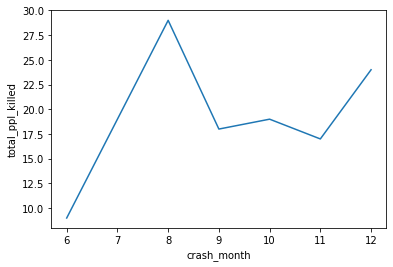

In [23]:
sns.lineplot(x="crash_month", y="total_ppl_killed", data=df_mvcc16)

# Show on the map
- for GIS and other analysis

In [24]:
MVCCDfAnalysis.filter(MVCCDfAnalysis["num_person_killed"] > 4)

crash_date,crash_time,borough,zip,lat,long,loca,on_street_name,cross_street_name,off_street_name,num_person_injured,num_person_killed,num_pedestrians_injured,num_pedestrians_killed,num_cyclist_injured,num_cyclist_killed,num_motorist_injured,num_motorist_killed,contributing_factor_venicle_1,contributing_factor_venicle_2,contributing_factor_venicle_3,contributing_factor_venicle_4,contributing_factor_venicle_5,collision_id,venicle_type_code_1,venicle_type_code_2,venicle_type_code_3,venicle_type_code_4,venicle_type_code_5
2017-10-31,15:08,MANHATTAN,10014.0,40.729046,-74.01073,"(40.729046, -74.0...",WEST STREET ...,WEST HOUSTON STREET,null,12.0,8.0,7,6,1,2,4,0,Other Vehicular,Unspecified,Unspecified,Unspecified,Unspecified,3782508,Flat Bed,Bus,Bike,Bike,Bike


In [25]:
loca_lat = MVCCDfAnalysis.filter(MVCCDfAnalysis["num_person_killed"] > 4).select("lat").collect()[0][0]
loca_long = MVCCDfAnalysis.filter(MVCCDfAnalysis["num_person_killed"] > 4).select("long").collect()[0][0]

In [27]:
max_num_pp_killed = folium.Map(location=[loca_lat, loca_long], zoom_start=10)
marker = folium.CircleMarker(
    location=[loca_lat, loca_long],
    radius=50,
    popup="11 times",
    color="#ee150e",
    fill=True,
    fill_color="#ff8581"
    )
marker.add_to(max_num_pp_killed)


In [28]:
max_num_pp_killed